In [17]:
from coffea.nanoevents import BaseSchema, NanoEventsFactory
import dask_awkward as dak
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import hist
import mplhep as hep
import numba
import vector
vector.register_awkward()

In [18]:
# Load events with BaseSchema
events = NanoEventsFactory.from_root(
    file="./p8_ee_ZH_ecm240/events_101027117.root:events",
    schemaclass=BaseSchema,
    # schemaclass=DelphesSchema, Doesn't work 
    # schemaclass=NanoAODSchema.v7, Doesn't work
    metadata={
        "path":"/eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_ZH_ecm240/events_101027117.root",
        "name":"p8_ee_ZH_ecm240",
        "process":"ZH to mumu, ecm=240 GeV"
    }
).events()

In [19]:
# Filter out any events which no reconstructed particles
Recon = events['ReconstructedParticles/ReconstructedParticles.energy'].compute()
useful_events = events[ak.num(Recon) > 0]

In [20]:
def index_mask(input_array, index_array):
    '''
    This function matches the given attribute of ReconstructedParticles (for example energy) to the particle index (for example Muon or Electron)
    '''
    if len(input_array) != len(index_array) :
        raise Exception('Length of Input_array and index_array does not match!')
    counts = len(ak.count(input_array, axis = 1))
    @numba.jit
    def numba_wrap(input_array, index_array,counts):
        output_array = []
        for event_index in range(counts):
            event_mask = index_array[event_index]
            reco_list = input_array[event_index]
            output_array.append([reco_list[i] for i in  event_mask])
        return output_array
    return ak.Array(numba_wrap(input_array,index_array,counts))

In [21]:
Muon_index = useful_events['Muon#0/Muon#0.index'].compute()

In [22]:
# Generate Reconstructed Particle Attributes
Reco_E = useful_events['ReconstructedParticles/ReconstructedParticles.energy'].compute()
Reco_px = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.x'].compute()
Reco_py = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.y'].compute()
Reco_pz = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.z'].compute()
Reco_q = useful_events['ReconstructedParticles/ReconstructedParticles.charge'].compute()
Reco_mass = useful_events['ReconstructedParticles/ReconstructedParticles.mass'].compute()

In [23]:
# Generate Muon Attributes
Muon_E = index_mask(Reco_E,Muon_index)
Muon_px = index_mask(Reco_px,Muon_index)
Muon_py = index_mask(Reco_py,Muon_index)
Muon_pz = index_mask(Reco_pz,Muon_index)
Muon_q = index_mask(Reco_q,Muon_index)
Muon_mass = index_mask(Reco_mass,Muon_index)

In [24]:
# Create Array of Muon Lorentz Vector 
Muon = ak.zip({"px":Muon_px,"py":Muon_py,"pz":Muon_pz,"E":Muon_E,"q":Muon_q,}, with_name="Momentum4D")

In [25]:
# Produce combinations of Muon Pairs possible within an event
combs = ak.combinations(Muon,2)

In [26]:
# Get DiMuons
mu1 , mu2 = ak.unzip(combs)
di_muon = mu1 + mu2

In [27]:
# Choose the dimuon with highest mass
di_muon = di_muon[ak.num(di_muon) > 0]
di_muon_mass = ak.Array([i[0] for i in ak.sort(di_muon.mass, ascending=False)])

In [28]:
# Choose dimuon which is made up of two oppositely charged muons
q_sum = mu1.q + mu2.q
q_sum_array = q_sum[ak.num(q_sum)>0]
q_sum_mask = ak.all(q_sum_array == 0, axis=1)
Z_cand_m = di_muon_mass[q_sum_mask]
Z_cand = di_muon[q_sum_mask]

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff04a581bb0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

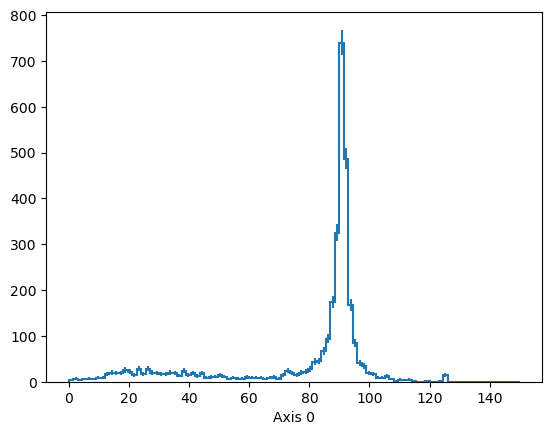

In [29]:
# Plot the mass of the Z-Candidate
hist_Zm = hist.Hist.new.Regular(100,0,150).Double().fill(Z_cand_m)
hist_Zm.plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff04a7e8440>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

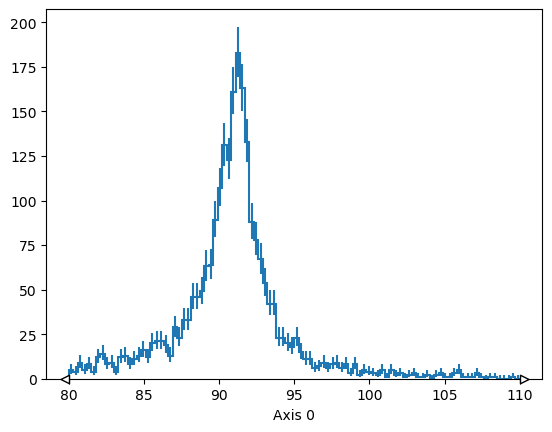

In [30]:
# Zoomed plot 1
hist.Hist.new.Regular(100,80,110).Double().fill(Z_cand_m).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff04a5f5400>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

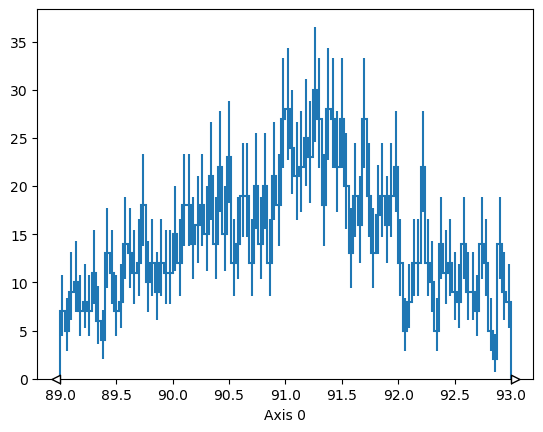

In [31]:
#Zoomed plot 2
hist.Hist.new.Regular(100,89,93).Double().fill(Z_cand_m).plot()

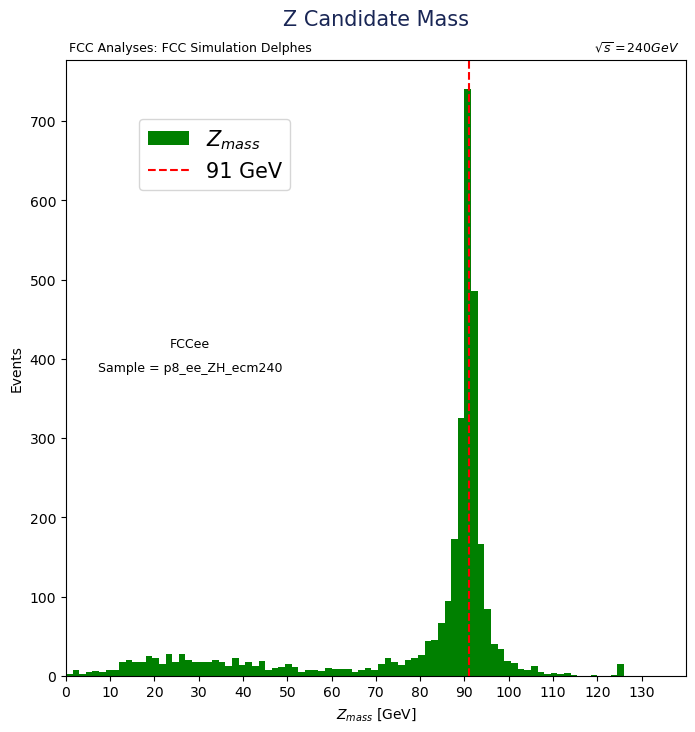

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
hep.histplot(
    hist_Zm,
    yerr=0,
    histtype='fill',
    label='$Z_{mass}$',
    color='g',
    ax=ax
)
xlims = [0,140]
# plt.text("Preliminary",0,0)
ax.text(0.20, 1.02, 'FCC Analyses: FCC Simulation Delphes', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.92, 1.02, '$\\sqrt{s} = 240GeV$', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.20,0.54, 'FCCee', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.20,0.50, 'Sample = p8_ee_ZH_ecm240', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel("Events")
ax.set_xlabel("$Z_{mass}$ [GeV]")
plt.xlim([0,140])
plt.xticks(np.arange(xlims[0],xlims[1],10))
ax.set_title(r"Z Candidate Mass",pad=25,  fontsize= "15", color="#192655")
ax.axvline(91,label="91 GeV", color='r', linestyle='--')
fig.legend(prop={"size":15},loc= (0.20,0.74) )
fig.savefig('./Z_Peak.png',dpi=240);

In [34]:
#Recoil Calculation
ecm = 240 #GeV # com energy
initial = ak.zip({"px":0,"py":0,"pz":0,"E":ecm}, with_name="Momentum4D")
Recoil = initial - Z_cand

In [49]:
hist_Recoil = hist.Hist.new.Regular(100,60,160).Double().fill(ak.flatten(Recoil.mass))
hist_Recoil

Hist(Regular(100, 60, 160, label='Axis 0'), storage=Double()) # Sum: 2682.0 (3148.0 with flow)

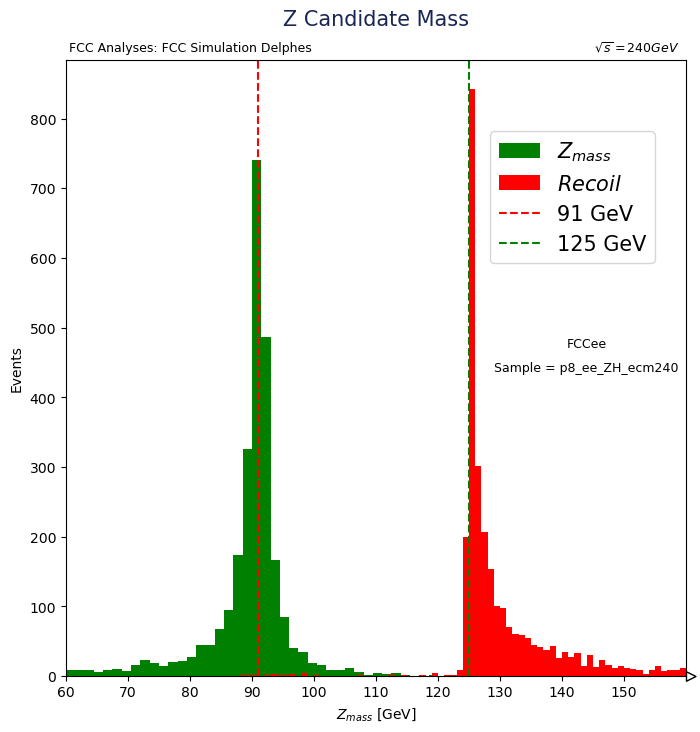

In [54]:
fig, ax = plt.subplots(figsize=(8,8))
hep.histplot(
    hist_Zm,
    yerr=0,
    histtype='fill',
    label='$Z_{mass}$',
    color='g',
    ax=ax
)
hep.histplot(
    hist_Recoil,
    yerr=0,
    histtype='fill',
    label='$Recoil$',
    color='r',
    ax=ax
)
xlims = [60,160]
# plt.text("Preliminary",0,0)
ax.text(0.20, 1.02, 'FCC Analyses: FCC Simulation Delphes', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.92, 1.02, '$\\sqrt{s} = 240GeV$', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.84,0.54, 'FCCee', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.84,0.50, 'Sample = p8_ee_ZH_ecm240', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel("Events")
ax.set_xlabel("$Z_{mass}$ [GeV]")
plt.xlim(xlims)
plt.xticks(np.arange(xlims[0],xlims[1],10))
ax.set_title(r"Z Candidate Mass",pad=25,  fontsize= "15", color="#192655")
ax.axvline(91,label="91 GeV", color='r', linestyle='--')
ax.axvline(125,label="125 GeV", color='g', linestyle='--')
fig.legend(prop={"size":15},loc= (0.70,0.64) )
fig.savefig('./Z_Peak_with_recoil.png',dpi=240);